# Simulation of Gender Proportions in Hiring(Sean)

This notebook explores a simulation-based approach to study gender proportions in hiring decisions and their evolution over multiple iterations. The key questions addressed are:

1. How does the inclusion of hiring policies that enforce gender balance affect workforce composition?
2. How do penalties for unqualified hires and gender imbalance impact hiring decisions?
3. How do total scores and gender proportions evolve over iterations?

## Steps:

1. **Generate Candidate Pools**: At each iteration, create a pool of 5 male and 5 female candidates,each assigned random scores within a predefined range.

2. **Evaluate Hiring Decisions**: Using the formula:
    Score = new scores + old total score - PenaltyUnqualified - PenaltyGenderImbalance
    determine the optimal number of hires for each gender. Ensure that if hiring occurs, at least one candidate is hired from each gender.

3. **Update Workforce**: Update the total workforce composition and scores based on the hiring decisions.

4. **Track Metrics**: Record the proportion of men in the workforce and the total scores after each iteration.

5. **Visualize Results**: Plot the evolution of gender proportions and total scores over the iterations to analyze the effects of the hiring policies and penalties.

The simulation provides insights into how specific hiring policies and constraints influence gender balanceand workforce quality over time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def initialize_workforce(initial_males, initial_females, male_score_range, female_score_range):
    # Score Initialization
    male_average_score = (male_score_range[0] + male_score_range[1]) / 2
    female_average_score = (female_score_range[0] + female_score_range[1]) / 2
    male_total_score = male_average_score * initial_males
    female_total_score = female_average_score * initial_females

    # Gender Proportion
    total_males = initial_males
    total_females = initial_females
    r_values = [total_males / (total_males + total_females)] 
    total_scores = [male_total_score + female_total_score]

    return male_total_score, female_total_score, total_males, total_females, r_values, total_scores

# Generate new candidates
def generate_candidate_pools(candidate_pool_size, male_score_range, female_score_range):
    male_scores = np.random.uniform(male_score_range[0], male_score_range[1], candidate_pool_size)
    female_scores = np.random.uniform(female_score_range[0], female_score_range[1], candidate_pool_size)
    return male_scores, female_scores

def evaluate_combinations(male_scores, 
                          female_scores, 
                          candidate_pool_size, 
                          total_males, 
                          total_females, 
                          male_total_score, 
                          female_total_score, 
                          Q_min, 
                          penalty_weight, 
                          gamma):
    male_combinations = list(product([0, 1], repeat=candidate_pool_size))
    female_combinations = list(product([0, 1], repeat=candidate_pool_size))

    # Do argmax
    best_score = -np.inf
    best_male_hires, best_female_hires = 0, 0

    for male_combo in male_combinations:
        for female_combo in female_combinations:
            male_hires = np.array(male_combo)
            female_hires = np.array(female_combo)

            # Make sure hire at least one for each gender or no hire at all
            if np.sum(male_hires) == 0 or np.sum(female_hires) == 0:
                continue

            new_male_score = np.sum(male_hires * male_scores)
            new_female_score = np.sum(female_hires * female_scores)
            unqualified_penalty = penalty_weight * (
                np.sum(male_hires[male_scores < Q_min]) +
                np.sum(female_hires[female_scores < Q_min])
            )
            gender_imbalance_penalty = gamma * abs((total_males + np.sum(male_hires)) - (total_females + np.sum(female_hires)))

            # Objective Score Calculation
            objective_score = (new_male_score + new_female_score + male_total_score + female_total_score
                - unqualified_penalty - gender_imbalance_penalty
            )

            if objective_score > best_score:
                best_score = objective_score
                best_male_hires = np.sum(male_hires)
                best_female_hires = np.sum(female_hires)

    return best_male_hires, best_female_hires

# Update Score
def update_workforce(male_scores, 
                     female_scores, 
                     best_male_hires, 
                     best_female_hires, 
                     male_total_score, 
                     female_total_score, 
                     total_males, 
                     total_females):
    male_total_score += np.sum(male_scores[:best_male_hires])
    female_total_score += np.sum(female_scores[:best_female_hires])
    total_males += best_male_hires
    total_females += best_female_hires
    return male_total_score, female_total_score, total_males, total_females

def simulation(iterations, 
               initial_males, 
               initial_females, 
               male_score_range, 
               female_score_range, 
               candidate_pool_size, 
               Q_min, 
               penalty_weight, 
               gamma):
    male_total_score, female_total_score, total_males, total_females, r_values, total_scores = initialize_workforce(
        initial_males, initial_females, male_score_range, female_score_range
    )

    for t in range(iterations):
        male_scores, female_scores = generate_candidate_pools(candidate_pool_size, male_score_range, female_score_range)

        best_male_hires, best_female_hires = evaluate_combinations(
            male_scores, female_scores, candidate_pool_size, total_males, total_females, 
            male_total_score, female_total_score, Q_min, penalty_weight, gamma
        )

        male_total_score, female_total_score, total_males, total_females = update_workforce(
            male_scores, female_scores, best_male_hires, best_female_hires, 
            male_total_score, female_total_score, total_males, total_females
        )

        r_new = total_males / (total_males + total_females)
        r_values.append(r_new)
        total_scores.append(male_total_score + female_total_score)

    return r_values, total_scores

def plot_results(r_values, total_scores):
    plt.figure(figsize=(12, 6))

    # Plot gender proportion
    plt.subplot(1, 2, 1)
    plt.plot(range(len(r_values)), r_values, marker='o', label="Proportion of Men (r_t)")
    plt.axhline(y=0.5, color='r', linestyle='--', label="Gender Balance (r=0.5)")
    plt.xlabel("Iteration")
    plt.ylabel("Proportion of Men (r_t)")
    plt.title("Change in Gender Proportion Over Iterations")
    plt.legend()
    plt.grid()

    # Plot total scores
    plt.subplot(1, 2, 2)
    plt.plot(range(len(total_scores)), total_scores, marker='x', color='g', label="Total Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Total Scores")
    plt.title("Total Score Over Iterations")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

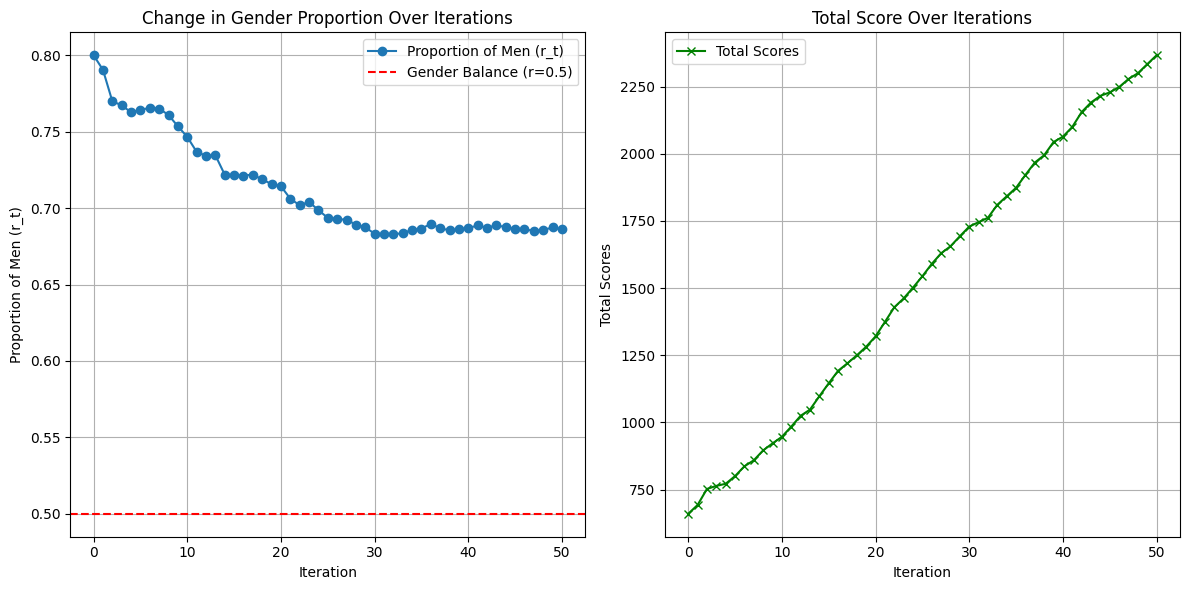

In [ ]:
# Priortize competence

# Parameters
iterations = 50
initial_males = 80
initial_females = 20
male_score_range = (4, 10)
female_score_range = (2, 8)
candidate_pool_size = 5

Q_min = 6 # Min score for hire, or get a penalty
penalty_weight = 30 # penalty constant for unqualified hire
gamma = 5 # penalty for gender imbalance

# Run simulation
r_values, total_scores = simulation(
    iterations, initial_males, initial_females, male_score_range, female_score_range, 
    candidate_pool_size, Q_min, penalty_weight, gamma
)

# Plot results
plot_results(r_values, total_scores)

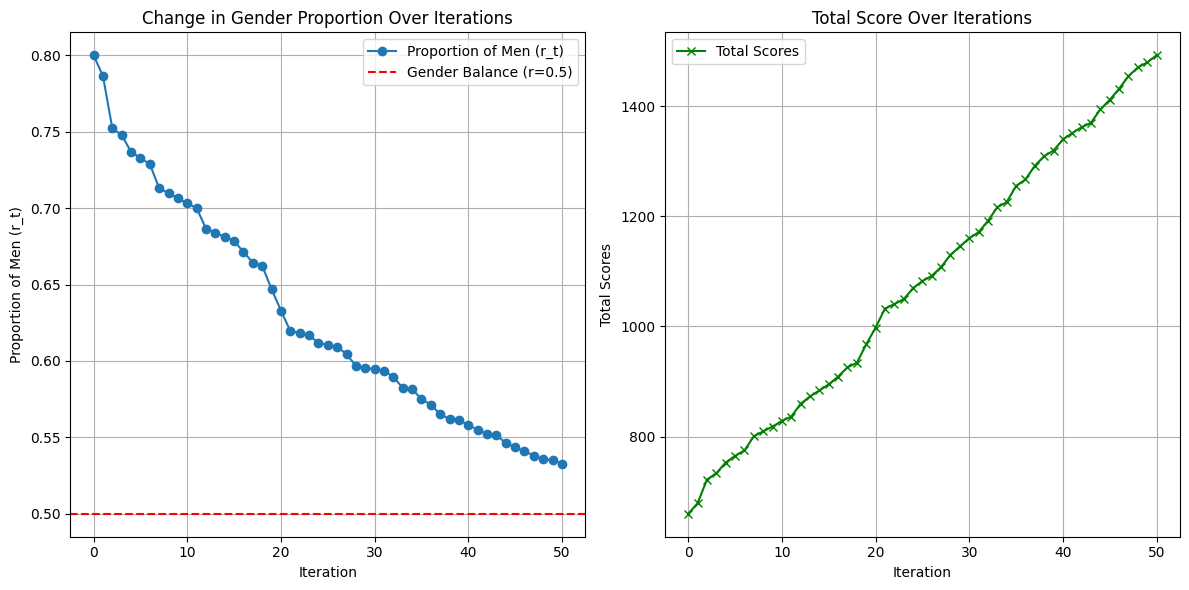

In [ ]:
# Priortize gender equality

penalty_weight = 20 
gamma = 10

r_values, total_scores = simulation(
    iterations, initial_males, initial_females, male_score_range, female_score_range, 
    candidate_pool_size, Q_min, penalty_weight, gamma
)

# Plot results
plot_results(r_values, total_scores)